In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import splprep, splev
import metody_optymalizacji

bounds = [(-2, 2), (-2, 2)] #- Przestrzeń decyzyjna U to kwadrat [-2, 2] x [-2, 2]
initial_guess = [0.0, 0.0] #-Punkt startowy dla optymalizatora

# --- 1. Definicja Funkcji Celu ---
def F1(u): return (u[0] - 1)**2 + u[1]**2     
def F2(u): return (u[0] + 1)**2 + u[1]**2

# --- 1. Definicja Funkcji Celu (wektorowa) ---

def F(u): return np.array([F1(u), F2(u)])

# Zbieramy wyniki tutaj
results = {
    'linear': {'P': [], 'FP': []},
    'epsilon': {'P': [], 'FP': []},
    'distance': {'P': [], 'FP': []}
}

# Liczba kroków (punktów do wyznaczenia na froncie)
NUM_STEPS = 21


Uruchamiam metodę 1: Skalaryzacja Liniowa...
Uruchamiam metodę 3: Minimalizacja Odległości (L2)...
Obliczenia zakończone. Wizualizacja...


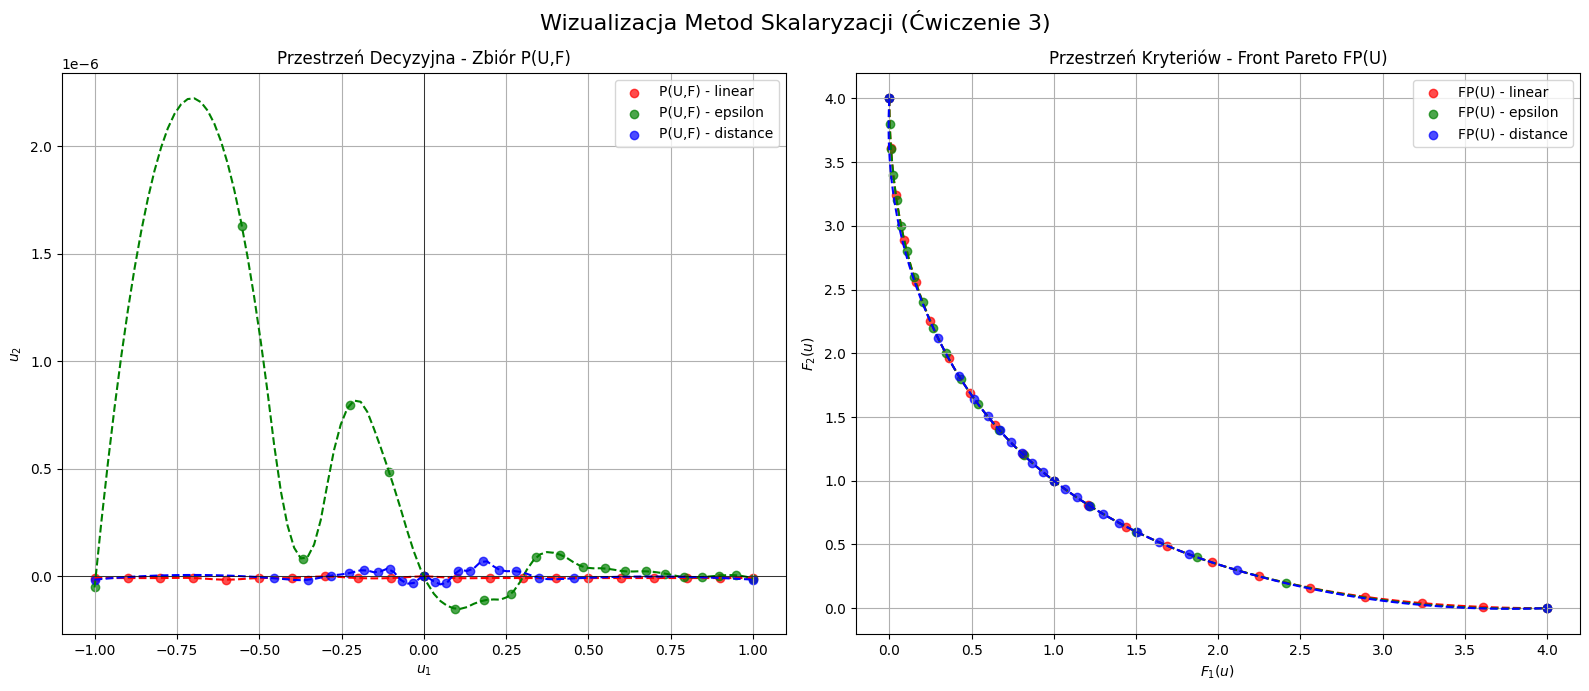

In [ ]:
# --- 2. Implementacja Metod Skalaryzacji ---

# --- Metoda 1: Skalaryzacja Liniowa (Ważona suma) ---

print("Uruchamiam metodę 1: Skalaryzacja Liniowa...")
for alpha in np.linspace(0, 1, NUM_STEPS):
    
    def objective_linear(u):
        return alpha * F1(u) + (1 - alpha) * F2(u)
    
    res = minimize(objective_linear, initial_guess, method='SLSQP', bounds=bounds)
    
    if res.success:
        results['linear']['P'].append(res.x)
        results['linear']['FP'].append(F(res.x))

# --- Metoda 2: Metoda Epsilon-Ograniczeń ---

for epsilon in np.linspace(0, 4, NUM_STEPS):
    
    # Ograniczenie: F2(u) <= epsilon  =>  epsilon - F2(u) >= 0
    constraints = ({'type': 'ineq', 'fun': lambda u: epsilon - F2(u)})
    objective_epsilon = F1
    
    res = minimize(objective_epsilon, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if res.success and F2(res.x) <= epsilon + 1e-6: 
        results['epsilon']['P'].append(res.x)
        results['epsilon']['FP'].append(F(res.x))


# --- Metoda 3: Minimalizacja Odległości (Utopia/Ideal Point) ---
# S3(u, alpha, p=2) = min [ alpha*(F1(u)-x1*)^2 + (1-alpha)*(F2(u)-x2*)^2 ]
print("Uruchamiam metodę 3: Minimalizacja Odległości (L2)...")
ideal_point = np.array([0.0, 0.0])

for alpha in np.linspace(0, 1, NUM_STEPS):
    
    def objective_distance(u):
        f = F(u)
        return alpha * (f[0] - ideal_point[0])**2 + (1 - alpha) * (f[1] - ideal_point[1])**2
        
    res = minimize(objective_distance, initial_guess, method='SLSQP', bounds=bounds)
    
    if res.success:
        results['distance']['P'].append(res.x)
        results['distance']['FP'].append(F(res.x))

print("Obliczenia zakończone. Wizualizacja...")

# --- 3. Wizualizacja Wyników ---

def plot_results(results_dict):
    """Pomocnicza funkcja do rysowania wyników"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    colors = {'linear': 'r', 'epsilon': 'g', 'distance': 'b'}
    
    for method_name, data in results_dict.items():
        if not data['P']:
            print(f"Brak wyników dla metody: {method_name}")
            continue

        p_points = np.array(data['P'])  
        fp_points = np.array(data['FP']) 
        
        ax1.scatter(p_points[:, 0], p_points[:, 1], 
                    c=colors[method_name], label=f"P(U,F) - {method_name}", alpha=0.7)
        
        try:
            sort_idx_p = np.argsort(p_points[:, 0])
            p_sorted = p_points[sort_idx_p]
            tck_p, u_p = splprep([p_sorted[:, 0], p_sorted[:, 1]], s=0, k=min(2, len(p_sorted)-1))
            u_new_p = np.linspace(u_p.min(), u_p.max(), 100)
            spline_p = splev(u_new_p, tck_p)
            ax1.plot(spline_p[0], spline_p[1], c=colors[method_name], linestyle='--')
        except Exception as e:
            print(f"Nie udało się dopasować splajnu P dla {method_name}: {e}")

        # --- Wykres 2: Przestrzeń Kryteriów (FP(U)) ---
        ax2.scatter(fp_points[:, 0], fp_points[:, 1], 
                    c=colors[method_name], label=f"FP(U) - {method_name}", alpha=0.7)
        
        try:
            sort_idx_fp = np.argsort(fp_points[:, 0])
            fp_sorted = fp_points[sort_idx_fp]
            tck_fp, u_fp = splprep([fp_sorted[:, 0], fp_sorted[:, 1]], s=0, k=min(2, len(fp_sorted)-1))
            u_new_fp = np.linspace(u_fp.min(), u_fp.max(), 100)
            spline_fp = splev(u_new_fp, tck_fp)
            ax2.plot(spline_fp[0], spline_fp[1], c=colors[method_name], linestyle='--')
        except Exception as e:
            print(f"Nie udało się dopasować splajnu FP dla {method_name}: {e}")

    ax1.set_title("Przestrzeń Decyzyjna - Zbiór P(U,F)")
    ax1.set_xlabel("$u_1$")
    ax1.set_ylabel("$u_2$")
    ax1.grid(True)
    ax1.legend()
    ax1.axhline(0, color='k', lw=0.5)
    ax1.axvline(0, color='k', lw=0.5)
    ax2.set_title("Przestrzeń Kryteriów - Front Pareto FP(U)")
    ax2.set_xlabel("$F_1(u)$")
    ax2.set_ylabel("$F_2(u)$")
    ax2.grid(True)
    ax2.legend()
    
    plt.suptitle("Wizualizacja Metod Skalaryzacji (Ćwiczenie 3)", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_results(results)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import time

# --- 1. Definicja Problemu (3D) ---

bounds = [(-1, 1), (-1, 1), (-1, 1)]

# Punkt startowy dla optymalizatora
initial_guess = [0.0, 0.0, 0.0]

def G1(u): return (u[0] - 1)**2 + u[1]**2 + u[2]**2

def G2(u): return (u[0] + 1)**2 + u[1]**2 + u[2]**2

def G3(u): return u[0]**2 + (u[1] - 1)**2 + u[2]**2

def G(u): return np.array([G1(u), G2(u), G3(u)])

# --- 2. Implementacja Metod Skalaryzacji ---

results = {
    'linear': {'P': [], 'FP': []},
    'epsilon': {'P': [], 'FP': []},
    'distance_cheby': {'P': [], 'FP': []}
}

# Liczba kroków na wymiar 
NUM_STEPS = 11 # 11 da 11*12/2 = 66 wag, 9 da 9*10/2 = 45 wag

Uruchamiam metodę 1: Skalaryzacja Liniowa (3D)...
Skończono w 0.15s. Znaleziono 66 punktów.

Uruchamiam metodę 2: Epsilon-Ograniczenia (3D)...
Skończono w 0.73s. Znaleziono 69 punktów.

Uruchamiam metodę 3: Odległość Czebyszewa (L-inf)...
Skończono w 0.16s. Znaleziono 36 punktów.

Wizualizacja 3D...


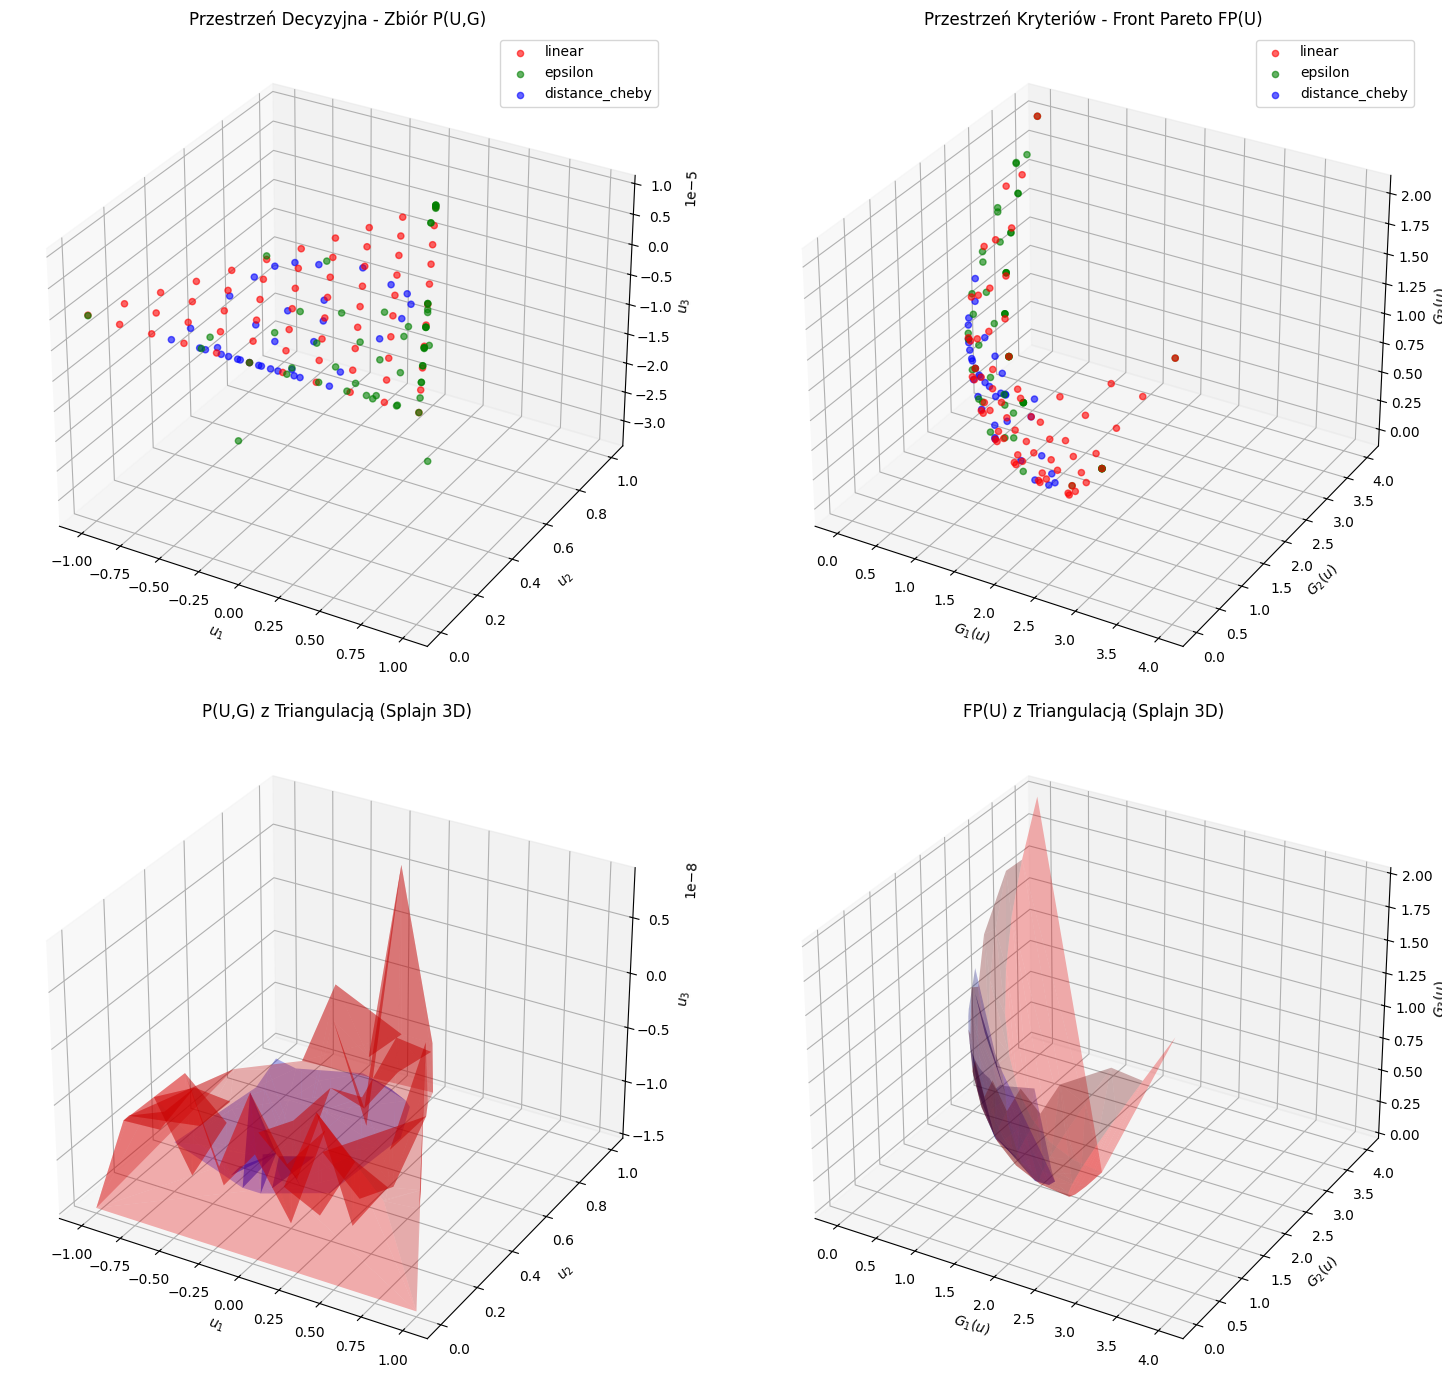

In [ ]:
# --- Metoda 1: Skalaryzacja Liniowa ---
print("Uruchamiam metodę 1: Skalaryzacja Liniowa (3D)...")
start_time = time.time()
weights = []
for i in range(NUM_STEPS):
    for j in range(NUM_STEPS - i):
        k = (NUM_STEPS - 1) - i - j
        w = np.array([i, j, k]) / (NUM_STEPS - 1)
        weights.append(w)

for w in weights:
    def objective_linear(u):
        return w[0] * G1(u) + w[1] * G2(u) + w[2] * G3(u)
    
    res = minimize(objective_linear, initial_guess, method='SLSQP', bounds=bounds)
    
    if res.success:
        results['linear']['P'].append(res.x)
        results['linear']['FP'].append(G(res.x))
print(f"Skończono w {time.time() - start_time:.2f}s. Znaleziono {len(results['linear']['FP'])} punktów.")

# --- Metoda 2: Metoda Epsilon-Ograniczeń ---
print("\nUruchamiam metodę 2: Epsilon-Ograniczenia (3D)...")
start_time = time.time()

N_EPS = 9 # Użyjmy mniejszej liczby kroków (9x9 = 81 optymalizacji)
for eps2 in np.linspace(0, 4, N_EPS):
    for eps3 in np.linspace(0, 2, N_EPS):
        constraints = (
            {'type': 'ineq', 'fun': lambda u: eps2 - G2(u)},
            {'type': 'ineq', 'fun': lambda u: eps3 - G3(u)}
        )
        
        res = minimize(G1, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        
        if res.success:
            results['epsilon']['P'].append(res.x)
            results['epsilon']['FP'].append(G(res.x))
print(f"Skończono w {time.time() - start_time:.2f}s. Znaleziono {len(results['epsilon']['FP'])} punktów.")

# --- Metoda 3: Minimalizacja Odległości (Chebyshev, L-nieskończoność) ---

print("\nUruchamiam metodę 3: Odległość Czebyszewa (L-inf)...")
start_time = time.time()
ideal_point = np.array([0.0, 0.0, 0.0])

for w in weights:
    if np.any(w == 0): continue
        
    def objective_cheby(uz):
        return uz[3] 
    
    bounds_cheby = bounds + [(0, None)] 
    
    constraints_cheby = (
        # z >= w1 * (G1 - x1*)
        {'type': 'ineq', 'fun': lambda uz: uz[3] - w[0] * (G1(uz[0:3]) - ideal_point[0])},
        # z >= w2 * (G2 - x2*)
        {'type': 'ineq', 'fun': lambda uz: uz[3] - w[1] * (G2(uz[0:3]) - ideal_point[1])},
        # z >= w3 * (G3 - x3*)
        {'type': 'ineq', 'fun': lambda uz: uz[3] - w[2] * (G3(uz[0:3]) - ideal_point[2])}
    )
    
    u_g = initial_guess
    z_g = np.max(w * (G(u_g) - ideal_point))
    initial_guess_cheby = np.append(u_g, z_g)
    
    res = minimize(objective_cheby, initial_guess_cheby, method='SLSQP', bounds=bounds_cheby, constraints=constraints_cheby)
    
    if res.success:
        u_solution = res.x[0:3]
        results['distance_cheby']['P'].append(u_solution)
        results['distance_cheby']['FP'].append(G(u_solution))
print(f"Skończono w {time.time() - start_time:.2f}s. Znaleziono {len(results['distance_cheby']['FP'])} punktów.")

# --- 3. Wizualizacja Wyników (3D) ---
print("\nWizualizacja 3D...")

def plot_results_3d(results_dict):
    fig = plt.figure(figsize=(16, 14))
    
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.set_title("Przestrzeń Decyzyjna - Zbiór P(U,G)")
    ax1.set_xlabel("$u_1$")
    ax1.set_ylabel("$u_2$")
    ax1.set_zlabel("$u_3$")
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    ax2.set_title("Przestrzeń Kryteriów - Front Pareto FP(U)")
    ax2.set_xlabel("$G_1(u)$")
    ax2.set_ylabel("$G_2(u)$")
    ax2.set_zlabel("$G_3(u)$")
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax3.set_title("P(U,G) z Triangulacją (Splajn 3D)")
    ax3.set_xlabel("$u_1$")
    ax3.set_ylabel("$u_2$")
    ax3.set_zlabel("$u_3$")
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    ax4.set_title("FP(U) z Triangulacją (Splajn 3D)")
    ax4.set_xlabel("$G_1(u)$")
    ax4.set_ylabel("$G_2(u)$")
    ax4.set_zlabel("$G_3(u)$")

    colors = {'linear': 'r', 'epsilon': 'g', 'distance_cheby': 'b'}
    
    for method_name, data in results_dict.items():
        if not data['P']:
            print(f"Brak wyników dla metody: {method_name}")
            continue
            
        p_points = np.array(data['P'])
        fp_points = np.array(data['FP'])
        
        _, idx_p = np.unique(p_points, axis=0, return_index=True)
        p_unique = p_points[idx_p]
        
        _, idx_fp = np.unique(fp_points, axis=0, return_index=True)
        fp_unique = fp_points[idx_fp]

        ax1.scatter(p_unique[:, 0], p_unique[:, 1], p_unique[:, 2], 
                    c=colors[method_name], label=method_name, alpha=0.6)
        ax2.scatter(fp_unique[:, 0], fp_unique[:, 1], fp_unique[:, 2], 
                    c=colors[method_name], label=method_name, alpha=0.6)


        if method_name in ['linear', 'distance_cheby'] and len(p_unique) > 3:
            try:
                ax3.plot_trisurf(p_unique[:, 0], p_unique[:, 1], p_unique[:, 2], 
                                 color=colors[method_name], alpha=0.3)
                ax4.plot_trisurf(fp_unique[:, 0], fp_unique[:, 1], fp_unique[:, 2], 
                                 color=colors[method_name], alpha=0.3)
            except Exception as e:
                print(f"Nie udało się narysować siatki dla {method_name}: {e}")
        
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

plot_results_3d(results)